In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../../lib")

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import temporal_encoder_common
from temporal_encoder_common import Filters
import nonneg_common
import lif_utils
import nengo
import dlop_ldn_function_bases as bases
import h5py
import tqdm

In [4]:
def unpack(As, As_shape):
    return np.unpackbits(
        As, count=np.prod(As_shape)).reshape(*As_shape).astype(np.float64)

In [5]:
with h5py.File("../../../data/generated/chapters/04_temporal_tuning/212fd1234166fc1b_spatio_temporal_network.h5", "r") as f:
    As_shape = f["As_shape"][()]
    xs_train = f["xs_train"][()]
    As_train = unpack(f["As_train"][()], As_shape)
    xs_test = f["xs_test"][()]
    As_test = unpack(f["As_test"][()], As_shape)

In [6]:
xs_train_flt = nengo.Lowpass(100e-3).filtfilt(xs_train)
As_train_flt = nengo.Lowpass(100e-3).filtfilt(As_train)

xs_test_flt = nengo.Lowpass(100e-3).filtfilt(xs_test)
As_test_flt = nengo.Lowpass(100e-3).filtfilt(As_test)

In [14]:
def dist(xs, N_wnd=1000, dt=1e-3):
    N = xs.shape[0]
    res = np.zeros(N)
    for i in tqdm.tqdm(range(N)):
        x_last = xs[i]
        for j in range(N_wnd):
            if i - j >= 0:
                x_new = xs[i - j]
            res[i] += np.linalg.norm(x_new - x_last)
            x_last = x_new
    return res

In [17]:
ds_test = dist(xs_test_flt)
ds_train = dist(xs_train_flt)

100%|██████████| 100000/100000 [09:48<00:00, 169.86it/s]


In [19]:
def ddist(xs, N_wnd=1000, dt=1e-3):
    N = xs.shape[0]
    res = np.zeros(N)
    for i in tqdm.tqdm(range(N)):
        for j in range(N_wnd):
            if i - j >= 0:
                res[i] += np.linalg.norm(xs[i - j]) * dt
    return res

In [24]:
dds_test = ddist(xs_test_flt)
dds_train = ddist(xs_train_flt)

100%|██████████| 100000/100000 [08:51<00:00, 188.04it/s]


In [21]:
D = np.linalg.lstsq(As_train_flt, ds_train, rcond=1e-2)[0]

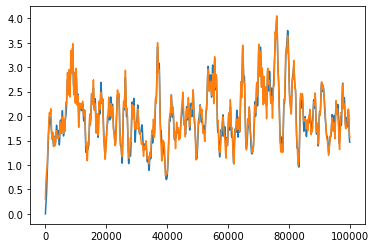

In [22]:
fig, ax = plt.subplots()
ax.plot(ds_train)
ax.plot(As_train_flt @ D)

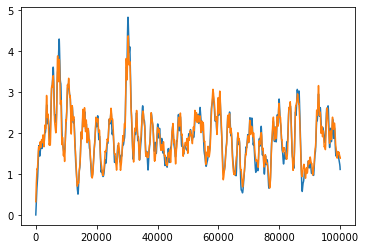

In [23]:
fig, ax = plt.subplots()
ax.plot(ds_test)
ax.plot(As_test_flt @ D)

In [25]:
D = np.linalg.lstsq(As_train_flt, dds_train, rcond=1e-2)[0]

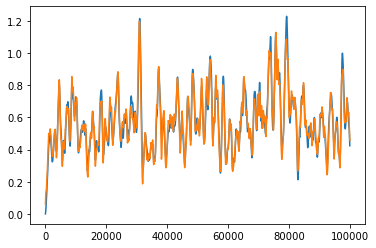

In [26]:
fig, ax = plt.subplots()
ax.plot(dds_train)
ax.plot(As_train_flt @ D)

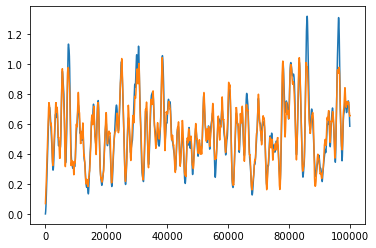

In [27]:
fig, ax = plt.subplots()
ax.plot(dds_test)
ax.plot(As_test_flt @ D)

In [43]:
def ddist_fast(xs, N_wnd=1000, dt=1e-3):
    N = xs.shape[0]
    res = np.zeros(N)
    ss = np.linalg.norm(xs, axis=1) * dt
    iss = np.cumsum(ss)
    return iss - np.concatenate((np.zeros(N_wnd), iss))[:N]

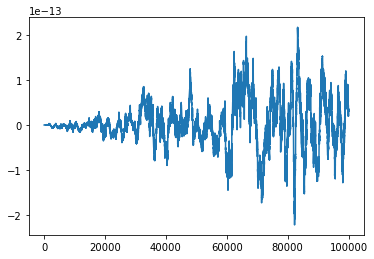

In [46]:
fig, ax = plt.subplots()
ax.plot(dds_test - ddist_fast(xs_test_flt))